In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from scipy.stats import ttest_ind, ttest_1samp

import sys
sys.path.append('./src')
from fid import calculate_fid
from data import PPCI

/nfs/scistore19/locatgrp/rcadei/ISTAnt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experriment settings 
(6480 total models)

- **Encoder**: clip, clip_large, dino, mae, vit, vit_large
- **Token**: class, mean, all
- **Splitting criteria**: experiment, experiment_easy, position, position_easy, random, random_easy
- **Task**: all, or
- **Hidden Layers**: 1, 2
- **Learning Rate**: 0.05, 0.005, 0.0005
- **Seed** = 0, 1, 2, 3, 4

In [2]:
results = pd.read_csv("~/ISTAnt/results/istant_hq/experiments_result.csv", index_col=0)
results.sort_values(by='bacc', ascending=False)

,encoder,token,split_criteria,hidden_layers,task,lr,seed,color,loss_val,acc_val,bacc_val,TEB_val,acc,bacc,TEB,TEB_bin,EAD
359,dino,class,position_easy,2,or,0.0005,4,or,0.891570,0.891,0.874390,-0.046517,0.960473,0.966701,0.004461,0.006167,0.062312
163,dino,class,experiment_easy,1,or,0.0005,3,or,1.247136,0.907,0.905462,-0.060318,0.957917,0.964844,-0.012174,-0.012625,0.062312
178,dino,class,experiment_easy,2,or,0.0005,3,or,1.118117,0.897,0.913099,-0.063544,0.951326,0.963287,-0.010874,-0.011333,0.062312
1258,dino,all,experiment_easy,2,or,0.0005,3,or,1.185325,0.911,0.901780,-0.073888,0.961932,0.962418,-0.017651,-0.017493,0.062312
3221,clip_large,all,random_easy,1,or,0.0005,1,or,0.820608,0.920,0.927965,0.010943,0.953030,0.960551,0.011550,0.014819,0.062312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7208,vit,mean,position,1,all,0.0500,4,yellow,19.292248,0.185,0.480325,0.008115,0.163333,0.495961,-0.035482,-0.042535,0.030903
9368,vit_large,all,position,1,all,0.0500,4,yellow,18.204624,0.834,0.494662,0.013412,0.857992,0.495960,-0.030999,-0.026243,0.030903
5082,mae,class,position,2,all,0.0050,1,yellow,18.663055,0.489,0.524251,-0.007924,0.434337,0.495088,-0.033061,-0.123417,0.030903
7234,vit,mean,position,2,all,0.0500,2,yellow,19.384996,0.167,0.488458,0.006092,0.163788,0.494553,-0.035201,-0.013938,0.030903


## Annotation Sampling Mechanism

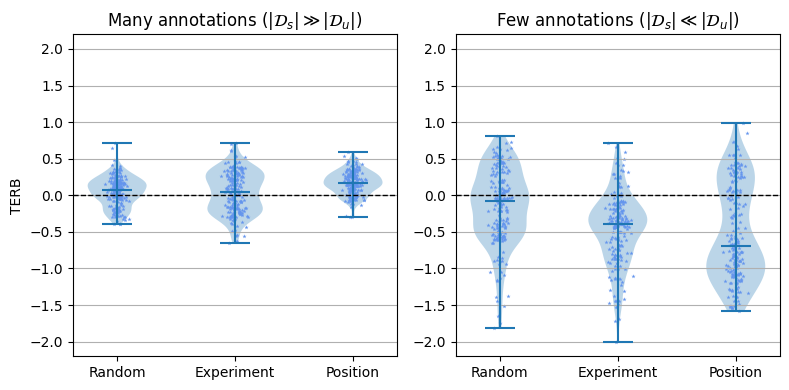

In [20]:
quality = "hq"
results = pd.read_csv(f"~/ISTAnt/results/istant_{quality}/experiments_result.csv", index_col=0)

task = results.task == 'or'
color = results.color == 'or'
results = results[task & color].sort_values("bacc", ascending=False)
n = 200

results["TERB"] = results["TEB"] / results["EAD"]
random_easy = results[results["split_criteria"] == "random_easy"][:n]
experiment_easy = results[results["split_criteria"] == "experiment_easy"][:n]
position_easy = results[results["split_criteria"] == "position_easy"][:n]

random = results[results["split_criteria"] == "random"][:n]
experiment = results[results["split_criteria"] == "experiment"][:n]
position = results[results["split_criteria"] == "position"][:n]

k = 2.2
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# plot violin plot
axs[0].violinplot([random_easy["TERB"], experiment_easy["TERB"], position_easy["TERB"]],
                  showmeans=False,
                  showmedians=True)
axs[0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[0].set_ylim(-k, k)
axs[0].set_title(r"Many annotations ($|\mathcal{D}_s| \gg |\mathcal{D}_u|$)")

for i, y in zip([1,2,3], [random_easy["TERB"], experiment_easy["TERB"], position_easy["TERB"]]):
    x = np.random.normal(i, 0.04, size=len(y))
    axs[0].scatter(x, y, alpha=1, color='cornflowerblue', s=10, marker='*', linewidths=0)

# plot box plot
axs[1].violinplot([random["TERB"], experiment["TERB"], position["TERB"]],
                  showmeans=False,
                  showmedians=True)
axs[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axs[1].set_title(r"Few annotations ($|\mathcal{D}_s| \ll |\mathcal{D}_u|$)")
axs[1].set_ylim(-k, k)

for i, y in zip([1,2,3], [random["TERB"], experiment["TERB"], position["TERB"]]):
    x = np.random.normal(i, 0.04, size=len(y))
    axs[1].scatter(x, y, alpha=1, color='cornflowerblue', s=10, marker='*', linewidths=0)

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(3)],
                  labels=['Random', 'Experiment', 'Position'])
axs[0].set_ylabel('TERB')

# save plot as pdf
plt.tight_layout()
plt.savefig(f"results/istant_{quality}/sampling_n{n}.pdf")
plt.show()

In [25]:
# t test random_easy has mean 0
t, pvalue = ttest_1samp(random_easy["TEB"], 0, alternative='two-sided')
print(f"Random Easy: t={t:.4f}, p={pvalue}, mu: {random_easy['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(random["TEB"], 0, alternative='two-sided')
print(f"Random: t={t:.4f}, p={pvalue}, mu: {random['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(experiment_easy["TEB"], 0, alternative='two-sided')
print(f"Experiment Easy: t={t:.4f}, p={pvalue}, mu: {experiment_easy['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(experiment["TEB"], 0, alternative='two-sided')
print(f"Experiment: t={t:.4f}, p={pvalue}, mu: {experiment['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(position_easy["TEB"], 0, alternative='two-sided')
print(f"Position Easy: t={t:.4f}, p={pvalue}, mu: {position_easy['TEB'].mean()*100:.2f}%")
t, pvalue = ttest_1samp(position["TEB"], 0, alternative='two-sided')
print(f"Position: t={t:.4f}, p={pvalue}, mu: {position['TEB'].mean()*100:.2f}%")

Random Easy: t=3.5814, p=0.00042952908996710717, mu: 0.32%
Random: t=-4.4640, p=1.3457377989025933e-05, mu: -1.02%
Experiment Easy: t=1.9187, p=0.05645887025153231, mu: 0.24%
Experiment: t=-13.4179, p=1.1695711710124526e-29, mu: -2.86%
Position Easy: t=14.9825, p=1.7957634842842818e-34, mu: 1.05%
Position: t=-11.2500, p=4.813606656897232e-23, mu: -3.22%


## Misleading Objective

lowest Balanced Accuracy: 0.4981465339660644


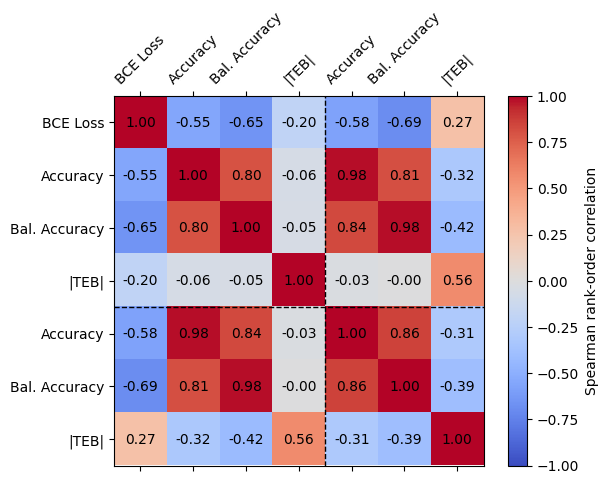

In [101]:
quality = "hq"
results = pd.read_csv(f"~/ISTAnt/results/istant_{quality}/experiments_result.csv", index_col=0)
n = 10000
task_name = "or"
color_name = "or"

split = (results["split_criteria"] == "random_easy") | (results["split_criteria"] == "experiment_easy") | (results["split_criteria"] == "position_easy")
task = results.task == task_name
color = results.color == color_name
results = results[~split & task & color].sort_values("bacc", ascending=False)[:n]
print(f"lowest Balanced Accuracy: {results['bacc'].iloc[-1]}")

results["TEB_val"] = results["TEB_val"].abs()
results["TEB"] = results["TEB"].abs()
results["TEB_bin"] = results["TEB"].abs()

corr_matrix = results[["loss_val", "acc_val", "bacc_val", "TEB_val", "acc", "bacc", "TEB"]].corr(method='spearman')
corr_matrix.columns = ['BCE Loss', 'Accuracy', 'Bal. Accuracy', '|TEB|', 'Accuracy', 'Bal. Accuracy', '|TEB|']

fig, ax = plt.subplots()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.axvline(x=3.5, color='black', linewidth=1, linestyle='--')
plt.axhline(y=3.5, color='black', linewidth=1, linestyle='--')
# add footnote at the bottom right
#plt.text(9, 6.4, "$_{val}$: Validation set\n$_{\mathcal{D}}$: Full dataset ($\mathcal{D}=\mathcal{D}_s \cup \mathcal{D}_u$)", fontsize=9, color='black')
colorbar = fig.colorbar(cax)
colorbar.set_label('Spearman rank-order correlation')
# save pdf
plt.savefig(f"results/istant_{quality}/evaluation_{color_name}_nolegend.pdf", bbox_inches='tight')
plt.show()

lowest Balanced Accuracy: 0.4981465339660644
1620


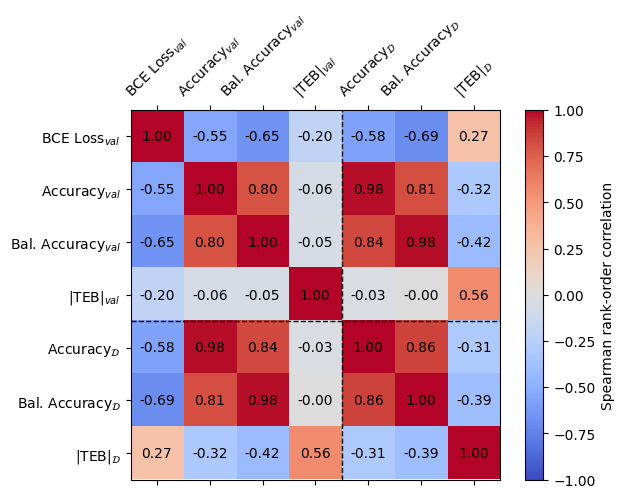

In [77]:
quality = "hq"
results = pd.read_csv(f"~/ISTAnt/results/istant_{quality}/experiments_result.csv", index_col=0)
n = 10000
task_name = "or"
color_name = "or"

split = (results["split_criteria"] == "random_easy") | (results["split_criteria"] == "experiment_easy") | (results["split_criteria"] == "position_easy")
task = results.task == task_name
color = results.color == color_name
results = results[~split & task & color].sort_values("bacc", ascending=False)[:n]
print(f"lowest Balanced Accuracy: {results['bacc'].iloc[-1]}")

print(len(results))
results["TEB_val"] = results["TEB_val"].abs()
results["TEB"] = results["TEB"].abs()
results["TEB_bin"] = results["TEB"].abs()

corr_matrix = results[["loss_val", "acc_val", "bacc_val", "TEB_val", "acc", "bacc", "TEB"]].corr(method='spearman')
corr_matrix.columns = ['BCE Loss$_{val}$', 'Accuracy$_{val}$', 'Bal. Accuracy$_{val}$', '|TEB|$_{val}$', 'Accuracy$_{\mathcal{D}}$', 'Bal. Accuracy$_{\mathcal{D}}$', '|TEB|$_{\mathcal{D}}$']

fig, ax = plt.subplots()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.axvline(x=3.5, color='black', linewidth=1, linestyle='--')
plt.axhline(y=3.5, color='black', linewidth=1, linestyle='--')
# add footnote at the bottom right
#plt.text(9, 6.4, "$_{val}$: Validation set\n$_{\mathcal{D}}$: Full dataset ($\mathcal{D}=\mathcal{D}_s \cup \mathcal{D}_u$)", fontsize=9, color='black')
colorbar = fig.colorbar(cax)
colorbar.set_label('Spearman rank-order correlation')
# save pdf
plt.savefig(f"results/istant_{quality}/evaluation_{color_name}.pdf", bbox_inches='tight')
plt.show()

## Representation Bias

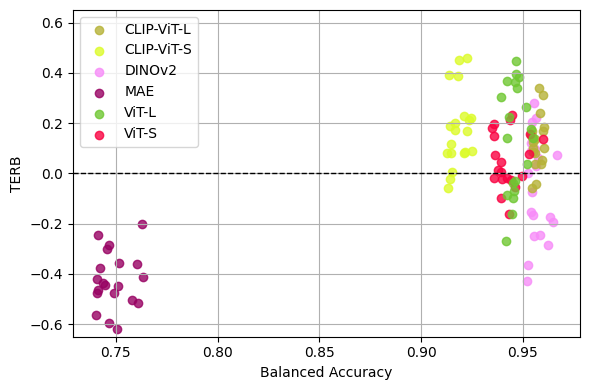

,acc,bacc,TEB,TEB_bin
encoder,,,,
DINOv2,0.945904,0.956809,-0.003598,-0.003141
CLIP-ViT-L,0.947426,0.956779,0.007865,0.010145
ViT-L,0.932831,0.946206,0.008833,0.010602
ViT-S,0.938472,0.942716,0.003305,0.004138
CLIP-ViT-S,0.897944,0.918145,0.010994,0.012061
MAE,0.712801,0.749138,-0.026524,-0.011039


In [100]:
quality = "hq"
np.random.seed(4)
results = pd.read_csv(f"~/ISTAnt/results/istant_{quality}/experiments_result.csv", index_col=0)
n = 20

split = (results["split_criteria"] == "random_easy") | (results["split_criteria"] == "experiment_easy") | (results["split_criteria"] == "position_easy")
task = results.task == 'or'
color = results.color == 'or'
results = results[task & color].sort_values("bacc", ascending=False)

# rename encoders
results["encoder"] = results["encoder"].replace({
    "vit_large": "ViT-L",
    "vit": "ViT-S",
    "clip_large": "CLIP-ViT-L",
    "clip": "CLIP-ViT-S",
    "mae": "MAE",
    "dino": "DINOv2"})


results["TERB"] = results["TEB"] / results["EAD"]
results = results.groupby("encoder").head(n)


encoders = results['encoder'].unique()
encoders_colors = {encoder: np.random.rand(3,) for encoder in encoders}
results['encoder_color'] = results['encoder'].map(encoders_colors)
plt.figure(figsize=(6, 4))
for encoder, color in encoders_colors.items():
    plt.scatter(results.loc[results['encoder'] == encoder, 'bacc'], 
                results.loc[results['encoder'] == encoder, 'TERB'],
                color=color, label=encoder, alpha=0.8)
# add hline in 0
k = 0.65
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
# add grid
plt.grid(True)
plt.xlabel("Balanced Accuracy")
plt.ylabel("TERB")
# set ylim
plt.ylim(-k, k)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.argsort(labels)
plt.legend(np.array(handles)[order], np.array(labels)[order])
plt.tight_layout()
plt.savefig(f"results/istant_{quality}/encoders_n{n}.pdf")
plt.show()


results = results.groupby("encoder").head(n).groupby("encoder").mean()[["acc", "bacc", "TEB", "TEB_bin"]].sort_values("bacc", ascending=False)
results


In [49]:
encoders = ["dino", "clip_large", "clip", "mae", "vit", "vit_large"]
splits = ["experiment", "experiment_easy", "position", "position_easy", "random", "random_easy"]
tokens = ["class", "mean"]
# save in pandas dataframe
results = pd.DataFrame(columns=["encoder", "token", "split", "fid"])
for encoder in encoders:
    for token in tokens:
        for split in splits:
            dataset = PPCI(encoder = encoder,
                        token = token,
                        #task = "or",
                        split_criteria = split,
                        environment = "supervised",
                        #batch_size = 256,
                        #num_proc = 4,
                        #verbose = True,
                        data_dir = 'data/istant_hq',
                        results_dir = 'results/istant_hq')
            embeddings = np.array(dataset.supervised["X"])
            # normalize embeddings
            embeddings = (embeddings - embeddings.mean(axis=0)) / embeddings.std(axis=0)
            A = embeddings[dataset.supervised["split"]]
            B = embeddings[~dataset.supervised["split"]]
            fid = calculate_fid(A, B)
            print(f"FID ({encoder}, {token}, {split},): {fid}")
            results = results.append({"encoder": encoder, "token": token,  "split": split, "fid": fid}, ignore_index=True)
results.to_csv("results/istant_hq/fid.csv")

FID (dino, class, experiment,): 212.99783428190557
FID (dino, class, experiment_easy,): 235.59011592243777
FID (dino, class, position,): 296.83416254661086
FID (dino, class, position_easy,): 308.84613773003696
FID (dino, class, random,): 201.17703934822183
FID (dino, class, random_easy,): 201.1770393482221
FID (dino, mean, experiment,): 548.0557052415455
FID (dino, mean, experiment_easy,): 655.5130130583528
FID (dino, mean, position,): 706.1450611781449
FID (dino, mean, position_easy,): 746.0049384919486
FID (dino, mean, random,): 518.8266011437098
FID (dino, mean, random_easy,): 518.8266011437419
FID (clip_large, class, experiment,): 320.74752196449964
FID (clip_large, class, experiment_easy,): 352.5813433974106
FID (clip_large, class, position,): 494.92478374771406
FID (clip_large, class, position_easy,): 492.28952023903025
FID (clip_large, class, random,): 346.4432188168322
FID (clip_large, class, random_easy,): 346.44321881675825
FID (clip_large, mean, experiment,): 528.90086264760

In [89]:
# load results
results = pd.read_csv("results/istant_hq/fid.csv", index_col=0)
split_name = "position"
results[(results["split"]==split_name) | (results["split"]==f"{split_name}_easy")].groupby("encoder").agg(["mean", "std"])["fid"]

,mean,std
encoder,,
clip,486.810054,97.675212
clip_large,605.269388,130.035898
dino,514.457575,244.945087
mae,760.922483,122.429178
vit,423.990197,103.988804
vit_large,681.796065,159.005026


## Discretization Bias

9720
lowest Balanced Accuracy: 0.9101494550704956
TEB=TEB_bin: p-value=1.90110520467876e-05, t-statistic=-4.277260829593264
|TEB|=|TEB_bin|: p-value=1.075022085801174e-25, t-statistic=-10.428245343602216
TEB=0: p-value=1.0622021940254747e-216, t-statistic=-32.23642288849235
TEB_bin=0: p-value=7.180906556812593e-104, t-statistic=-21.90627811257057


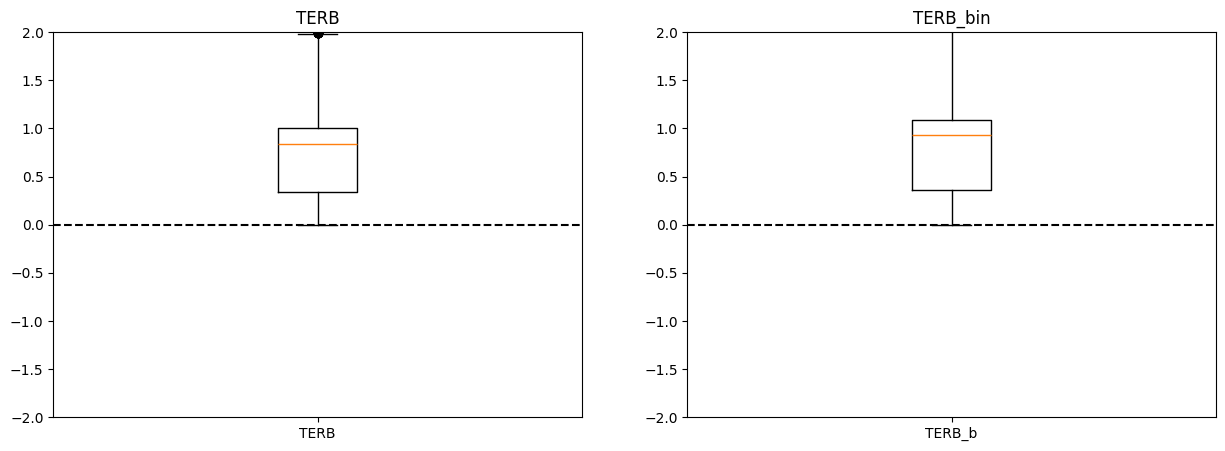

In [4]:
quality = "hq"
results = pd.read_csv(f"~/ISTAnt/results/istant_{quality}/experiments_result.csv", index_col=0)
n = 100000

split = (results["split_criteria"] == "random_easy") | (results["split_criteria"] == "experiment_easy") | (results["split_criteria"] == "position_easy")
task = results.task == 'or'
color = results.color == 'or'
#results = results[~split & task & color].sort_values("bacc", ascending=False)[:n]
print(len(results))
print(f"lowest Balanced Accuracy: {results['bacc'].iloc[-1]}")


t_statistic, p_value = ttest_ind(results['TEB'], results['TEB_bin'], alternative='two-sided')
print(f"TEB=TEB_bin: p-value={p_value}, t-statistic={t_statistic}")
t_statistic, p_value = ttest_ind(abs(results['TEB']), abs(results['TEB_bin']), alternative='less')
print(f"|TEB|=|TEB_bin|: p-value={p_value}, t-statistic={t_statistic}")
t_statistic, p_value = ttest_1samp(results['TEB'], 0, alternative='two-sided')
print(f"TEB=0: p-value={p_value}, t-statistic={t_statistic}")
t_statistic, p_value = ttest_1samp(results['TEB_bin'], 0, alternative='two-sided')
print(f"TEB_bin=0: p-value={p_value}, t-statistic={t_statistic}")

k = 2
# boxplots TEB and TEB_b
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
#fig.suptitle(f"TEB and TEB_b (ISTAnt {quality})")
axs[0].boxplot(abs(results['TEB']/results['EAD']), labels=["TERB"])
axs[0].set_title("TERB")
axs[0].axhline(y=0, color='black', linestyle='--')
axs[0].set_ylim(-k, k)
axs[1].boxplot(abs(results['TEB_bin']/results['EAD']), labels=["TERB_b"])
axs[1].set_title("TERB_bin")
axs[1].set_ylim(-k, k)
axs[1].axhline(y=0, color='black', linestyle='--')
plt.show()